In [828]:
import numpy as np
from tools import *
from fitters import *
from plots import *
from projectors import *
set_seaborn({'figure.figsize': (14,7)})
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [829]:

n_series = 9
series_rank = 3
shape = (n_series, series_rank)
# a_s = np.random.randn(*shape)*0.5
# e_s = np.array([1.5, 1.0, -0.8])
a_s = np.random.randn(*shape)
e_s = np.random.uniform(-1,1,size=series_rank)
e_s = np.array([1.5, 1.0, -0.8])

noise = 1e-3
beta = 1e-8
start_end = (0, 3)
dt = 0.01
dim = 10
window_factor = 2
offset = True
time = np.arange(start_end[0], start_end[1]+dt, dt)

X0s = []
Xps = []
X_series_s, Y_series_s = [], []

for i in range(n_series):
    X_series, Y_series, _, _ = build_exp_series(
        a_s[i], e_s, noise=noise, time=time)
    if len(X_series_s) > 0:
        shift = X_series_s[-1][-1]-X_series[0]
        X_series += shift
        Y_series += shift
    X_series = X_series[1:]
    Y_series = Y_series[1:]
    X_series_s.append(X_series)
    Y_series_s.append(Y_series)

X_series = np.concatenate(X_series_s)
Y_series = np.concatenate(Y_series_s)


N = len(X_series)
alltime = np.arange(0, N)
window = int(dim * window_factor) +2

thetas, ws, ress = [], [], []


for i in range(window, N, 1):

    sl = slice(i-window, i)
    Xhan = build_hankel(X_series[sl], dim)
    X0w = Xhan[:, :-1]
    Xpw = Xhan[:, 1:]

    Xp1 = Xpw[-1]
    
    if offset: 
        X01 = np.vstack((X0w, np.ones(X0w.shape[1])))
        reg_dim = dim + 1
    else:
        X01 = X0w
        reg_dim = dim 
    lam = beta * np.eye(reg_dim)

    a = (Xp1 @ X01.T) @ np.linalg.inv((X01 @ X01.T) + lam)
    if offset: 
        a, c = a[:-1], a[-1:]
    A = np.eye(dim, k=1)
    A[-1] = a

    w, vl = scipy.linalg.eig(A, left=True, right=False)

    sortorder = np.argsort(np.abs(w))
    w = w[sortorder][::-1]
    theta = vl[:, sortorder][:, -1]
    theta *= np.sign(theta[-1])
    thetas.append(theta)

    ws.append(w)
    # ress.append(res)
ress = np.array(ress)
ws = np.array(ws)
thetas = np.array(thetas)
true_w = np.exp(dt*np.max(e_s))

Xhan = build_hankel(X_series, dim)
theta_r = np.mean(thetas, axis=0)
P_series = theta_r.real @ Xhan


# P_series_b, theta_b, A = eig_companion(X_series, dim, beta=beta)
P_series_b, theta_b, A, c = eig_companion_Cshift(X_series, dim, beta=beta)


# take opt linear
# Xb = np.vstack((Xhan, np.ones(Xhan.shape[1])))
# lam = beta * np.eye(dim + 1)
# lam[-1, -1] = 0
# theta_opt = (Y_series[dim:] @ Xb.T) @ np.linalg.inv((Xb @ Xb.T) + lam)
# theta_opt, b = theta_opt[:-1], theta_opt[-1:]
# P_series_opt = theta_opt @ Xhan + b



# take real
# thetas_real = thetas[np.linalg.norm(thetas.imag, axis=1) == 0]
# theta_real = np.mean(thetas_real, axis=0)
# P_series_real = theta_real @ Xhan

# take opt eigval
# thetas_opt = thetas[np.isclose(ws[:, 0].real, true_w, atol=0.01)]
# theta_opt = np.mean(thetas_opt, axis=0)
# P_series_opt = theta_opt.real @ Xhan

# # compute nontransion
# X0s = []
# Xps = []
# for i in range(n_series):
#     Xhanw = build_hankel(X_series_s[i], dim)
#     X0 = Xhanw[:, :-1]
#     Xp = Xhanw[:, 1:]
#     X0Xp = X0 @ Xp.T
#     X0X0 = X0 @ X0.T
#     X0s.append(X0X0)
#     Xps.append(X0Xp)

# X0X0 = np.mean(X0s, axis=0)
# X0Xp = np.mean(Xps, axis=0)

# lam = beta * np.eye(dim)
# w, vl = scipy.linalg.eig(X0Xp, (X0X0+lam))

# vl =  vl[:, np.argsort(np.abs(w))[::-1]]
# theta_avg= vl[:, 0]
# w = np.sort(np.abs(w))[::-1]

# theta_avg /= theta_avg[-1]
# P_series_avg = theta_avg.real @ Xhan

# P_series_opt[P_series_opt> 0.1] = P_series_opt.mean()
# P_series_opt[P_series_opt < -0.1] = P_series_opt.mean()


print(true_w, thetas.shape, thetas_opt.shape)


1.015113064615719 (2678, 10) (121, 10)


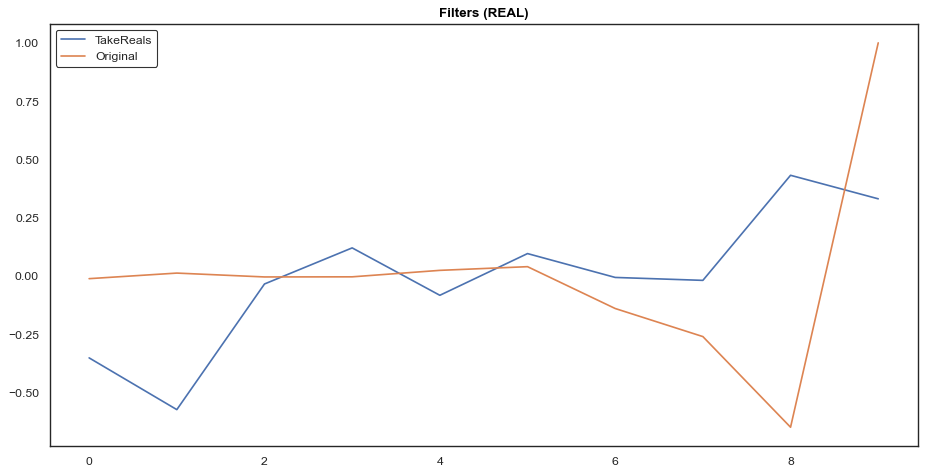

In [830]:
plt.plot(theta.real, label='TakeReals')
plt.plot(theta_b.real, label='Original')

plt.title('Filters (REAL)')
plt.legend()
plt.show()


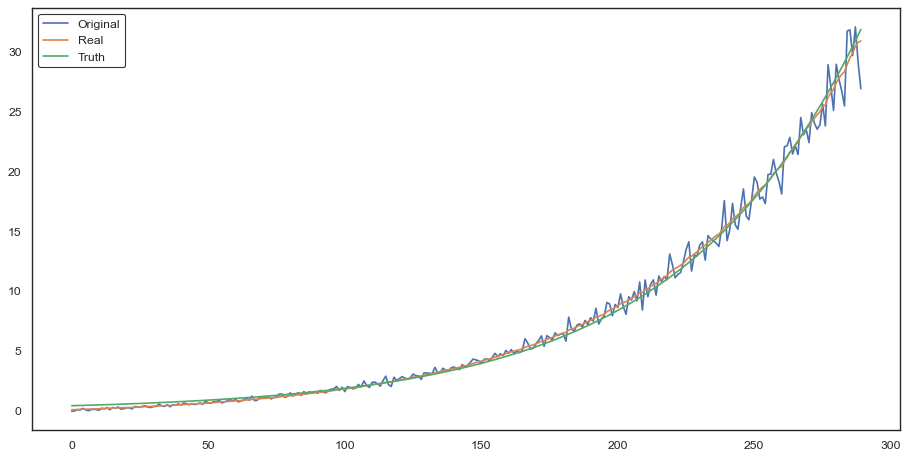

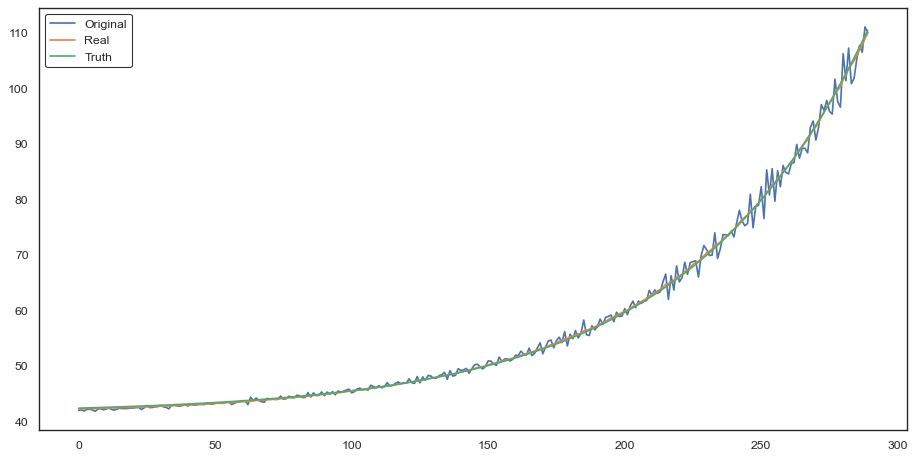

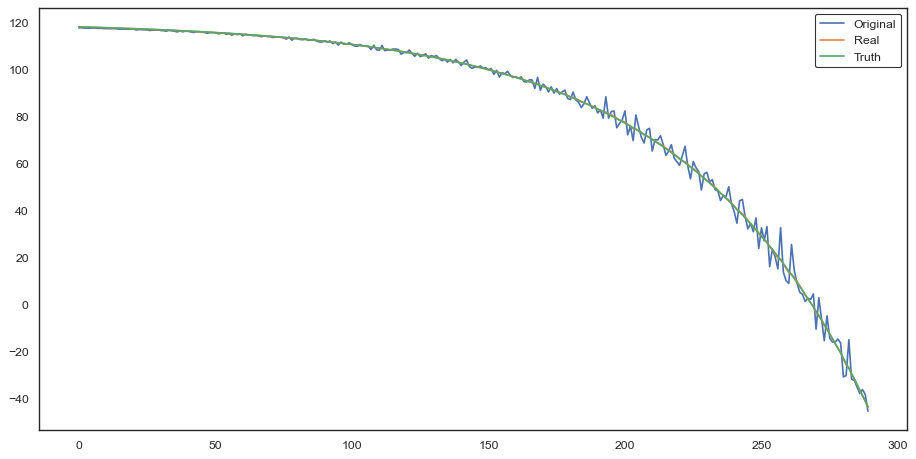

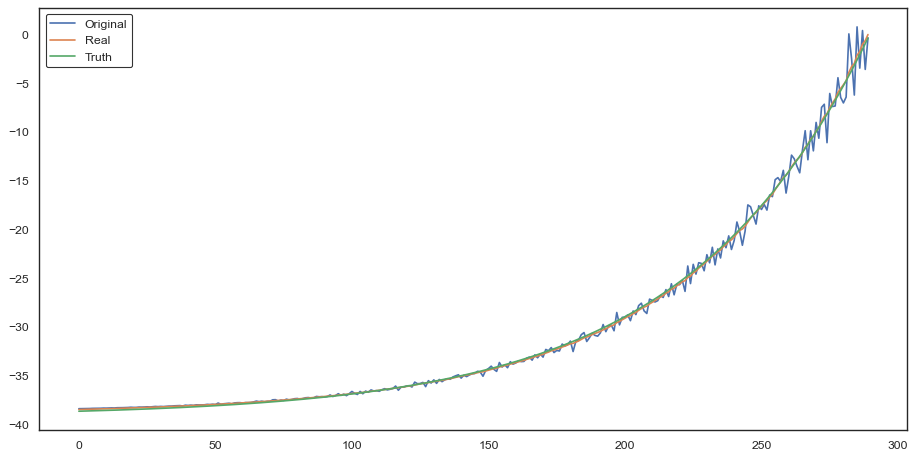

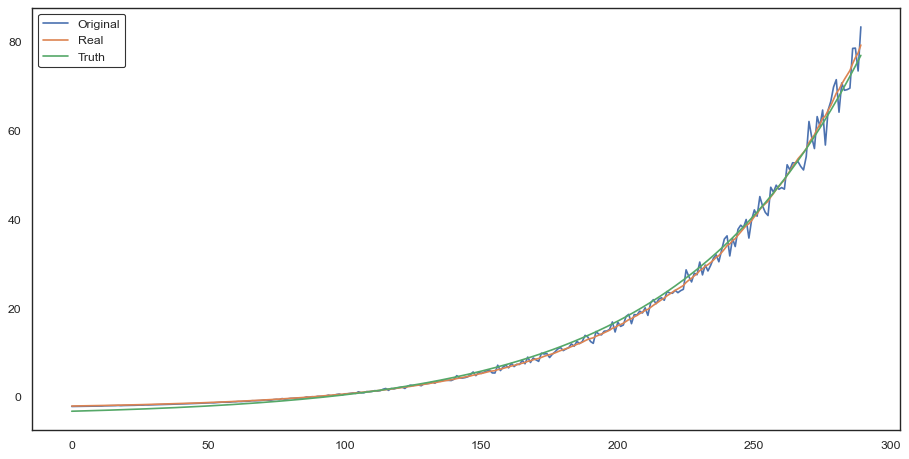

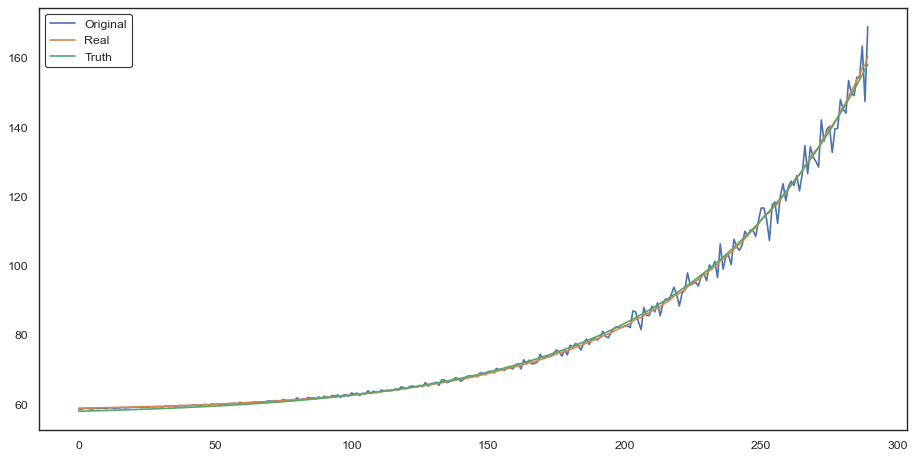

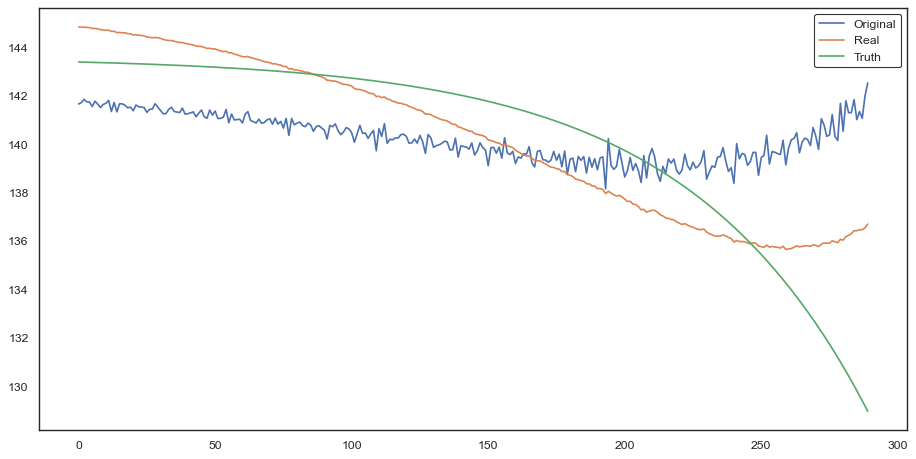

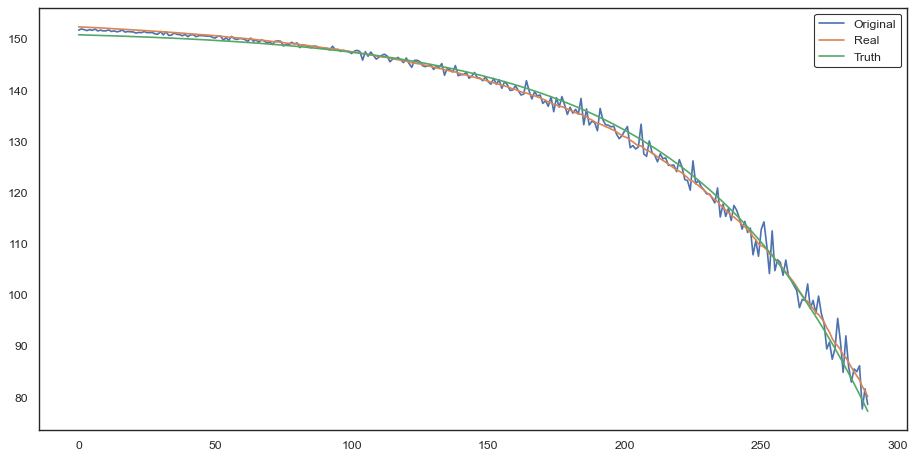

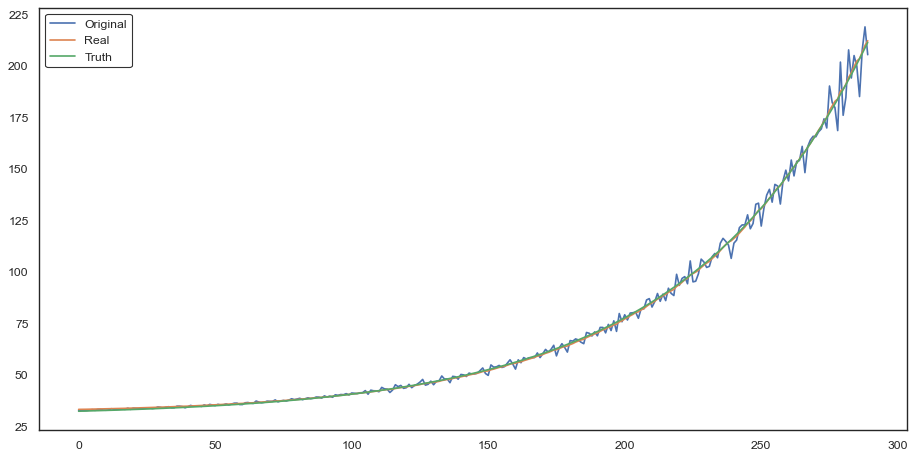

Err Original: 4.35688116824836
Err Real: 0.6843734417839554


In [831]:
err_reals = []
err_original = []
for i in range(n_series):
    fit_Y = Y_series_s[i][dim:]
    Xhan =  build_hankel(X_series_s[i], dim)
    p = theta_r.real @ Xhan

    fit_r = solve_scale_shift(p, fit_Y)
    err = mean_square_error(fit_r, fit_Y)
    err_reals.append(err)

    p = theta_b.real @ Xhan
    fit_o = solve_scale_shift(p, fit_Y)
    err = mean_square_error(fit_o, fit_Y)
    err_original.append(err)
    # plt.plot(X_series_s[i], label='X')
    # plt.plot(Y_series_s[i], label='Y')
    # plt.legend()
    # plt.show()
    plt.plot(fit_o, label='Original')
    plt.plot(fit_r, label='Real')
    plt.plot(fit_Y, label='Truth')
    plt.legend()
    plt.show()

    
print('Err Original:', np.mean(err_original, axis=0))   
print('Err Real:', np.mean(err_reals, axis=0))

In [832]:
print(len(X_series), len(time), dim, window)

2700 301 10 22


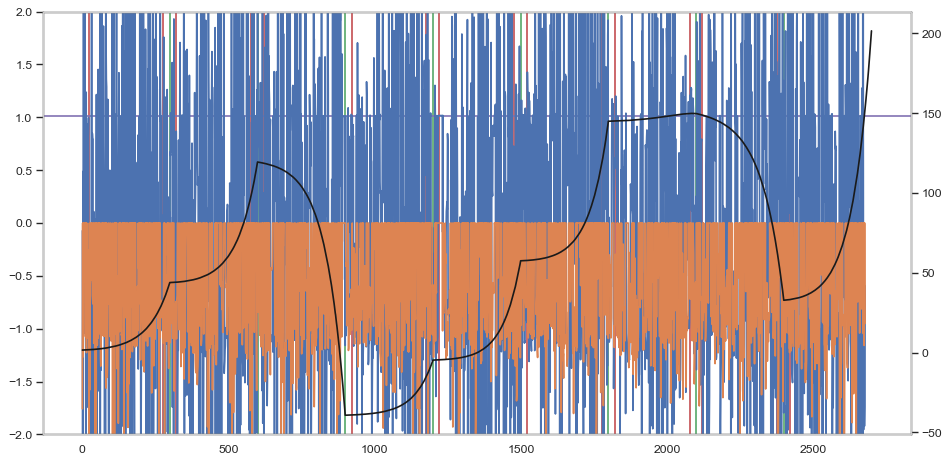

In [833]:
fig, ax = plt.subplots(1, 1)
ax.grid(False)
sns.set_style("whitegrid", {'axes.grid' : False})
# vlines = np.arange(window,0, len(time))
# ax.axvline(len(time)-window, color='r') 
[ax.axvline(len(time)*n-window-n-1, color='r') for n in range(1,n_series)]
[ax.axvline(len(time)*n+window-n-1, color='r') for n in range(0,n_series)]
[ax.axvline(len(time)*n-n-1, color='g') for n in range(1,n_series)]
# [ax.axvline(n*window-dim, color='r') for n in range(1,n_series)]
ax.axhline(true_w, color='m')
ax.plot(ws[:,0].real)
ax.plot(ws[:,0].imag)
# ax.plot(ws[:,1])

ax.set_ylim(-2,2)
ax2 = ax.twinx()
ax2.plot(X_series,c='k')
plt.show()

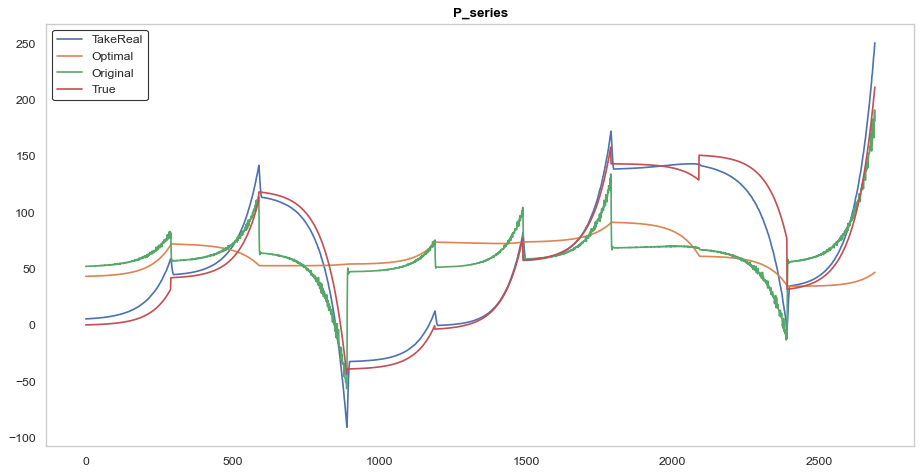

Err Opt: 3326.321442957809
Err TakeReal: 220.82798451932803
Err Original: 3025.193424656916


In [834]:

# plt.plot(P_series, label='TakeReal')
# plt.plot(P_series_opt, label='Optimal')
# plt.plot(P_series_b, label='Original')
# plt.plot(P_series_avg, label='Avg')
# plt.legend()
# plt.show()

fit_Y = Y_series[dim:]
fit_take = solve_scale_shift(P_series, fit_Y)
fit_original = solve_scale_shift(P_series_b, fit_Y)
fit_opt = solve_scale_shift(P_series_opt, fit_Y)

plt.plot(fit_take, label='TakeReal')
plt.plot(fit_opt, label='Optimal')
plt.plot(fit_original, label='Original')
plt.plot(fit_Y, label='True')
plt.title('P_series')
plt.legend()
plt.show()

err_take = mean_square_error(fit_take, fit_Y)
err_original = mean_square_error(fit_original, fit_Y)
err_opt = mean_square_error(fit_opt, fit_Y)

print('Err Opt:', err_opt)
print('Err TakeReal:', err_take)
print('Err Original:', err_original)


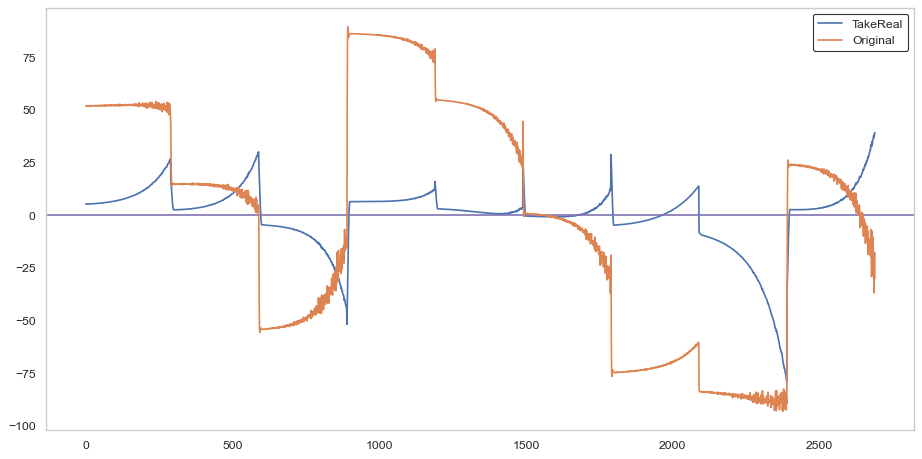

In [835]:
plt.plot(fit_take-fit_Y, label='TakeReal')
plt.axhline(0, color='m')
plt.plot(fit_original-fit_Y, label='Original')
plt.legend()
plt.show()

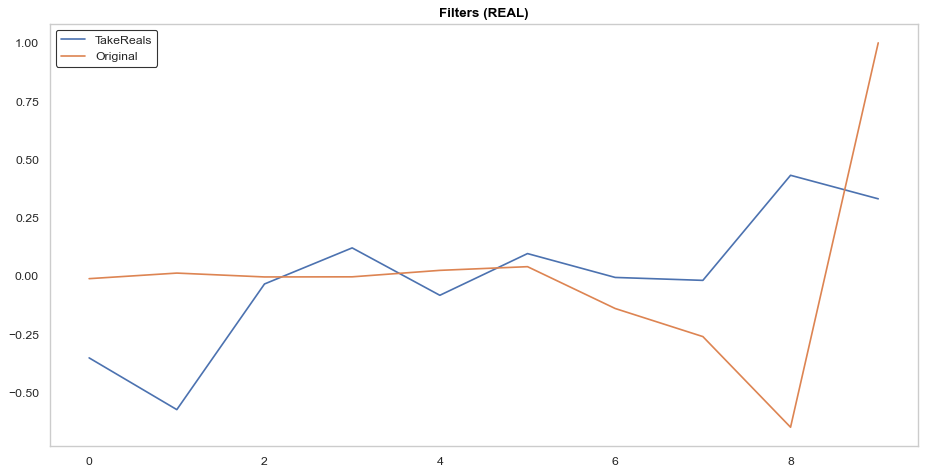

In [836]:
plt.plot(theta.real, label='TakeReals')
plt.plot(theta_b.real, label='Original')

plt.title('Filters (REAL)')
plt.legend()
plt.show()
